In [12]:
# Python script to estimate the STARS foam model parameter from experimental data. 
# This is a python adoption of a Julia script written by A.A. Eftekhari, see https://github.com/simulkade/foamparameters. 
# The optimization solver does not handle the bound constraints very well. It needs to be improved.

In [1]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [2]:
def find_indices(vector, condition):
    return [i for i, elem in enumerate(vector) if condition(elem)]


def relative_sort(vector1, vector2):
    return [x for _, x in sorted(zip(vector1, vector2))]

##########################$######################################

def sws(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    s_ws = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s > swc and s < (1-sgr):
            s_ws[i, 0] = (s-swc)/(1-sgr-swc)
        elif s>=(1-sgr):
            s_ws[i, 0] = 1
    return s_ws


def krg(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_g = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s >= swc:
            kr_g[i, 0] = krg0 * (1-sws(s)) ** ng
        elif s<swc:
            kr_g[i, 0] = 1+(krg0-1)/swc * s
    return kr_g


def krw(s_w):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    n_size = np.size(s_w, 0)
    kr_w = np.zeros((n_size, 1))
    for i in range(0, len(s_w)):
        s = s_w[i]
        if s <= (1 - sgr):
            kr_w[i, 0] = krw0 * sws(s) ** nw
        elif s > (1 - sgr):
            kr_w[i, 0] = (-(1 - krw0) / sgr * (1.0 - s) + 1.0)
    return kr_w


def dryout(x, sw):
    return 0.5 + np.arctan(x[1]*(sw-x[2]))/np.pi


def fm_mod_f2(s_w, f2):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    fm = 1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi)
    return fm


def fg_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam


def fm_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    s_w = np.reshape(s_w, (np.size(s_w), 1))
    mu_f = np.reshape(mu_f, (np.size(mu_f), 1))
    fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
          (f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])
    return fm


def fg_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam
########################################################################


In [43]:
data = pd.DataFrame(columns=['fg_exp','mu_exp','mu_water','mu_gas','u_exp','sw_exp'])
data['fg_exp']=[0.11142,
0.22251,
0.33109,
0.43742,
0.54062,
0.63953,
0.73413,
0.8256,
0.90929,
0.95256]

data['mu_exp'] = [0.74646,
0.82715,
0.87918,
0.93386,
0.97559,
1.0292,
1.0814,
1.1136,
0.91593,
0.36635]

data['u_exp'] = [1.4885E-05,
1.5121E-05,
1.5379E-05,
1.5673E-05,
1.5995E-05,
1.6307E-05,
1.6582E-05,
1.6853E-05,
1.62E-05,
1.5489E-05]

data['mu_water'] = np.ones(len(data))*1e-3

data['mu_gas'] = np.ones(len(data))*2e-05

# data['u_exp'] = np.ones(len(data))*2.89e-6

sigma_wg = 0.03 
muw = data['mu_water'].iloc[0]
mug = data['mu_gas'].iloc[0]

In [45]:
# Relperm data
swc = 0.05                                                                     # connate water saturation [-]
sgr = 0.03                                                                     # irreducable gas saturation [-]
nw = 4.423                                                                     # Corey water exponent [-]
ng = 0.938                                                                     # Corey gas exponent [-]
krg0 = 0.587                                                                   # endpoint gas relative permeability [-]
krw0 = 0.720

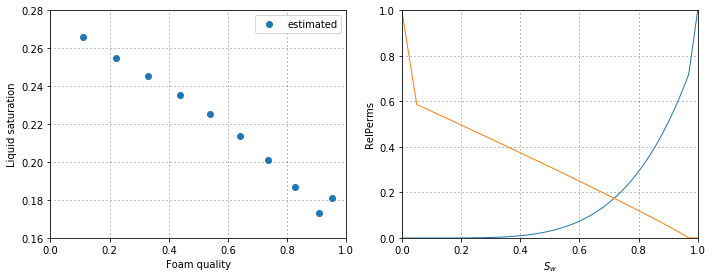

In [46]:
# sw_exp = np.zeros((n_data, 1))
sw_plt = np.reshape(np.linspace(0.0,1.0, 100), (len(np.linspace(0.0,1.0, 100)), 1))
data['sw_exp'] = (1-swc-sgr)*(data['mu_water']*(1-data['fg_exp'])/(krw0*data['mu_exp']))**(1/nw)+swc
# sw_exp = (1-swc-sgr)*(data['mu_water']*(1-data['fg_exp'])/(krw0*data['mu_exp']))**(1/nw)+swc
sw_exp = np.reshape(data['sw_exp'] ,(len(data['sw_exp'] ),1))

krg_plt = krg(sw_plt)
krw_plt = krw(sw_plt)

plt.figure(1, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(data['fg_exp'], data['sw_exp'], "o")
plt.xlabel("Foam quality")
plt.ylabel("Liquid saturation")
plt.legend(["estimated"])
plt.grid()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(sw_plt, krw_plt, sw_plt, krg_plt)
plt.xlabel(r"$S_w$")
plt.ylabel("RelPerms")
plt.grid()
plt.tight_layout()

In [47]:
transition = pd.DataFrame(np.nan,np.arange(1),columns=['trans_ind','fg_trans','mu_trans'])

# transition fron low- to high-quality
transition['trans_ind'] = data['mu_exp'].idxmax(axis=0, skipna=True)
transition['fg_trans']  = data['fg_exp'].iloc[transition['trans_ind'].iloc[0]]
transition['mu_trans']  = data['mu_exp'].iloc[transition['trans_ind'].iloc[0]]

sw_trans = (1-swc-sgr)*(data['mu_water'].iloc[transition['trans_ind'].iloc[0]]* \
                        (1-transition['fg_trans'].iloc[0])/(krw0*transition['mu_trans'].iloc[0]))**(1/nw)+swc

In [73]:
# Initial guess and bound constraints for least square parameter estimation
x0 = np.array([2.3e5,10000,0.17,1e-4 ,2.5])
# x0 = np.array([1e4, 1e4, 0.15, 0.001, 1.5])
# bound = ([10,10,swc,1e-4,0] , [1e8,1e5,sw_trans+0.05,1e-2,4])

lb                = [10,10,swc,1e-4,2.26]                            
ub                = [1e8,1e5,sw_trans+0.05,1e-3,4];      
bound =[lb,ub]

w = np.ones((np.size(sw_exp), 1))

w[transition['trans_ind'].iloc[0]-3:transition['trans_ind'].iloc[0]-1] = 5e8
w[transition['trans_ind'].iloc[0]:transition['trans_ind'].iloc[0]+2] = 3e6

# @variable(m4, 10<=fmmob4<=2e6)
# @variable(m4, swc<=fmdry4<=sw_exp[ind_mu_max])
# @variable(m4, 1e-5<=fmcap4<=1e-3)
# @variable(m4, 2.26<=epcap4<=4.0)
# w[[ind_mu_max-3:ind_mu_max-1]]   = 5e8     # fit 4
# w[ind_mu_max]   = 3e6                      # fit 4
# w[ind_mu_max+2] = 3e6 

In [75]:
# Least square 
labdaw = krw(sw_exp)/np.reshape(data['mu_water'],(len(data['mu_water']), 1))                                                 # water mobility
labdag = krg(sw_exp)/np.reshape(data['mu_gas'],(len(data['mu_water']), 1))    

muf_exp = np.reshape(data['mu_exp'],(len(data['mu_exp']),1))
u_exp = np.reshape(data['u_exp'],(len(data['u_exp']),1))

def misfit(x):
    return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
                                           (x[3]/(u_exp*muf_exp/sigma_wg))**x[4])))/muf_exp)**2)

es = optimize.least_squares(misfit, x0, bounds=bound)

foam_param = np.zeros((5, 0))
foam_param = es.x
foam_param = np.reshape(foam_param, (len(foam_param), 1))
param_ls = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_ls['fmmob'] = foam_param[0, 0]
param_ls['epdry'] = foam_param[1, 0]
param_ls['fmdry'] = foam_param[2, 0]
param_ls['fmcap'] = foam_param[3, 0]
param_ls['epcap'] = foam_param[4, 0]

print(param_ls)


          fmmob         epdry     fmdry    fmcap     epcap
0  1.450970e+06  10028.721042  0.161284  0.00013  2.492074


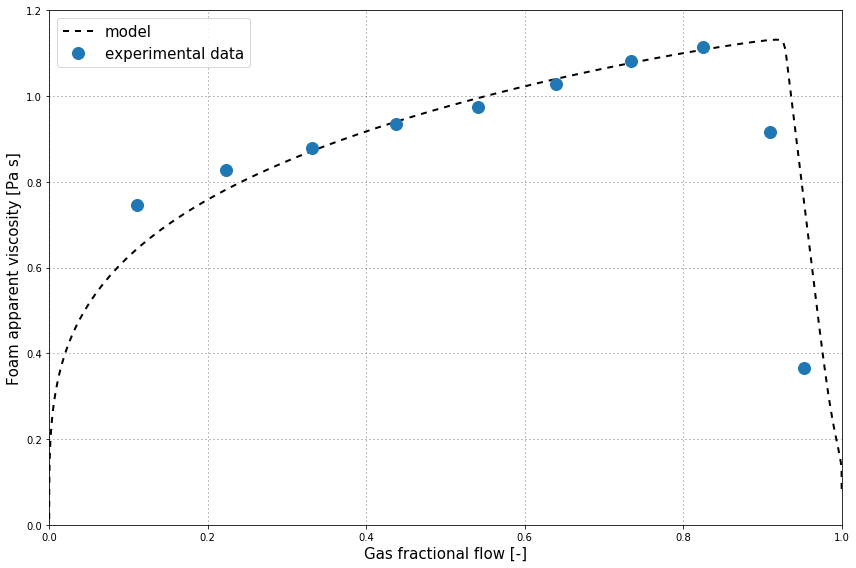

In [83]:
# Fit visualization
sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 300),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 300))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 300))

n1 = np.size(sw_val)
muf_opt = np.zeros((n1, 1))
u_min = np.min(data['u_exp'])
u_max = np.max(data['u_exp'])
u_ave = float(np.mean(data['u_exp']))

F22 = [foam_param[0, 0], foam_param[1, 0], foam_param[2, 0]]
F52 = [foam_param[3, 0], foam_param[4, 0]]

for i in range(0, n1):
    sw_p = float(sw_val[i])

    def fmu2(x):
        return float(x - muf_mod_f2f5(sw_p, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[i, 0] = sol.x


fg_opt = fg_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)

plt.figure(figsize=[12,8])
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2,label='model')
plt.plot(data['fg_exp'], data['mu_exp'], "o",markersize =12,label='experimental data')
plt.ylabel("Foam apparent viscosity [Pa s]",fontsize=15)
plt.xlabel("Gas fractional flow [-]",fontsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=15)

plt.show()

